# Spotify Recommender System

In [4]:
import sys, logging
import spotipy
import os
from json.decoder import JSONDecodeError
import spotipy.oauth2
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd
import spotipy.util as util
import matplotlib
import pdb
from IPython.display import HTML
from funcy import chunks
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from sklearn.cluster import KMeans
import numpy as np
from hdbscan import HDBSCAN
import hdbscan

logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)

pd.set_option('display.max_columns', 1000)

ModuleNotFoundError: No module named 'spotipy'

This model allows a user to choose a playlist of their liking, and provide the playlist ID to the application. The application then recommend the songs in that playlist that have the highest probability of being enjoyed by the user.

### Function definitions

In [2]:
def get_user_owned_playlist_contents(username, token, all_results, sp):
    '''
    Function to get all songs from spotify playlists created by user

    Args:
        username (str): Spotify username
        token (str): Spotify api session token
        all_results (dict): empty dictionary
        sp: (Spotify object): Spotify API session object

    Returns:
        all_results (dictionary): dictionary with songs as keys and metadata as values
        df_master (Pandas DataFrame): DataFrame of all_results dictionary 
    '''
    if token:
        # get all user's created playlists
        playlists = sp.user_playlists(username)
        # iterate through all of the playlists
        for playlist in playlists['items']:

            # filter only for playlists where the user is the owner, 
            # and filtering out some non-applicable playlists
            if (playlist['owner']['id'] == username) & (
                    'Archive' not in playlist['name']):
                tracks = sp.playlist(playlist['id'], fields="tracks,next")['tracks']

                tracks_total = tracks['items']

                while tracks['next']:
                    tracks = sp.next(tracks)  # get next page of tracks
                    tracks_total.extend(tracks['items'])  # extend master list

                for i in range(len(tracks_total)):
                    # get features/attributes of worth
                    song_id = tracks_total[i]['track']['id']

                    all_results[song_id] = {
                        'song_name':
                        tracks_total[i]['track']['name'],
                        'duration_ms':
                        tracks_total[i]['track']['duration_ms'],
                        'artist_name':
                        tracks_total[i]['track']['artists'][0]['name'],
                        'artist_id':
                        tracks_total[i]['track']['artists'][0]['id'],
                        'album_id':
                        tracks_total[i]['track']['album']['id'],
                        'album_name':
                        tracks_total[i]['track']['album']['name'],
                        'release_date':
                        tracks_total[i]['track']['album']['release_date'],
                        'popularity':
                        tracks_total[i]['track']['popularity'],
                        'explicit':
                        tracks_total[i]['track']['explicit']
                    }

        df_master = pd.DataFrame(all_results).T

        return all_results, df_master

    else:
        logger.info(f"Can't get saved songs for {username}")


def get_user_saved_songs(username, token, all_results, sp):
    '''
    Function to get all songs saved by a user

    Args:
        username (str): Spotify username
        token (str): Spotify api session token
        all_results (dict): dictionary with songs from get_user_owned_playlist_contents()
        sp: (Spotify object): Spotify API session object

    Returns:
        all_results (dictionary): dictionary with songs as keys and metadata as values, updated with saved songs
        df_master (Pandas DataFrame): DataFrame of all_results dictionary 
    '''

    if token:
        saved_songs = sp.current_user_saved_tracks()  # get user's saved tracks
        saved_songs_total = saved_songs['items']  # strip out the items

        while saved_songs['next']:
            saved_songs = sp.next(saved_songs)  # get next page of tracks
            saved_songs_total.extend(
                saved_songs['items'])  # extend master list

        for i in range(len(saved_songs_total)):
            song_id = saved_songs_total[i]['track']['id']  # get song id
            # pdb.set_trace()
            if song_id not in all_results.keys(
            ):  # only get info for songs that aren't already in the list

                all_results[song_id] = {
                    'song_name':
                    saved_songs_total[i]['track']['name'],
                    'duration_ms':
                    saved_songs_total[i]['track']['duration_ms'],
                    'artist_name':
                    saved_songs_total[i]['track']['artists'][0]['name'],
                    'artist_id':
                    saved_songs_total[i]['track']['artists'][0]['id'],
                    'album_id':
                    saved_songs_total[i]['track']['album']['id'],
                    'album_name':
                    saved_songs_total[i]['track']['album']['name'],
                    'release_date':
                    saved_songs_total[i]['track']['album']['release_date'],
                    'popularity':
                    saved_songs_total[i]['track']['popularity'],
                    'explicit':
                    saved_songs_total[i]['track']['explicit']
                }

        # create dataframe from song data
        df_master = pd.DataFrame(all_results).T

        return all_results, df_master

    else:
        logger.info(f"Can't get saved songs for {username}")


def get_deep_song_info(all_results, df_master, token, sp):
    '''
    Get deep audio features for every song

    Args:
        all_results (dict): dictionary with songs from get_user_owned_playlist_contents()
        df_master (DataFrame): DF of all_results
        token (str): Spotify api session token
        sp: (Spotify object): Spotify API session object

    Returns:
        all_audio_features (dictionary): dictionary with songs as keys and deep song features as values
        df_master (Pandas DataFrame): df_master merged with deep audio features
    '''
    if token:

        all_audio_features = dict()  # results dict for deep features

        # iterate through song ids in batches of 45
        for id_batch in chunks(45, all_results.keys()):

            # get audio features for batch
            batch_audio_features = sp.audio_features(id_batch)

            # create dictionary of song ids and features
            temp_dict = dict(zip(id_batch, batch_audio_features))

            # update main dictionary with results
            all_audio_features.update(temp_dict)

        # columns to drop
        drop_columns = [
            'duration_ms', 'type', 'analysis_url', 'track_href', 'uri', 'id'
        ]

        # create df from deep features and drop columns
        audio_features_df = pd.DataFrame(all_audio_features).T.drop(
            drop_columns, axis=1)

        # merge main df with deep df
        df_master = df_master.join(audio_features_df, on=df_master.index)
        return all_audio_features, df_master
    else:
        logger.info(f"Can't get deep song info for {username}")


def get_album_info(df_master, token, sp):
    '''
    Get album info for every song in df_master

    Args:
        df_master (DataFrame): DF returned from get_deep_song_info()
        token (str): Spotify api session token
        sp: (Spotify object): Spotify API session object

    Returns:
        albums_df (Pandas DataFrame): df with all album metadata/features
        df_master (Pandas DataFrame): df_master merged with albums_df/features
    '''
    if token:

        all_albums = dict()  # results dict for album features

        # iterate in batches
        for album_id_batch in chunks(20, df_master['album_id']):

            batch_albums = sp.albums(album_id_batch)  # get albums
            batch_albums = batch_albums['albums']  # only pull out album info
            # iterate thorugh album ids
            for i, album_id in enumerate(album_id_batch):
                # get only attributes of desire
                all_albums[album_id] = {
                    'record_label': batch_albums[i]['label'],
                    'album_popularity': batch_albums[i]['popularity']
                }
        # create df of albums data
        albums_df = pd.DataFrame(all_albums).T

        # merge master df with album df
        df_master = df_master.join(albums_df, on='album_id')

        return albums_df, df_master
    else:
        logger.info(f"Can't get albums for {username}")


def get_artist_info(df_master, token, sp):
    '''
    Get artist info for every song in df_master

    Args:
        df_master (DataFrame): DF returned from get_album_info()
        token (str): Spotify api session token
        sp: (Spotify object): Spotify API session object

    Returns:
        artists_df (Pandas DataFrame): df with all artist metadata/features
        df_master (Pandas DataFrame): df_master merged with artists_df/features
    '''
    if token:

        all_artists = dict()

        # iterate in batches

        for artist_id_batch in chunks(20, df_master['artist_id'].unique()):

            batch_artists = sp.artists(artist_id_batch)
            batch_artists = batch_artists['artists']
            for i, artist_id in enumerate(artist_id_batch):
                # get only attributes that are needed
                all_artists[artist_id] = {
                    'artist_followers': batch_artists[i]['followers']['total'],
                    'artist_genres': batch_artists[i]['genres'],
                    'artist_popularity': batch_artists[i]['popularity']
                }

        # create df of artists data
        artists_df = pd.DataFrame(all_artists).T
        artists_df['artist_genres'] = artists_df.artist_genres.apply(
            lambda x: [i.replace(' ', '_') for i in x])

        # merge master df with artists df
        df_master = df_master.join(artists_df, on='artist_id')

        return artists_df, df_master

    else:
        logger.info(f"Can't get artist info for {username}")


def get_playlist_tracks(username, playlist_id, sp):
    '''
    Return tracks and metadata from Spotify playlist by playlist ID

    Args:
        playlist_id (str): string identifying Spotify playlist e.g. '37i9dQZF1DXcBWIGoYBM5M'
        token (str): Spotify api session token
        sp: (Spotify object): Spotify API session object

    Returns:
        playlist_results (dictionary): dict with keys as songs and values as metadata
        playlist_df (Pandas DataFrame): df with all songs from playlist
    '''
    playlist_results = dict()

    tracks = sp.playlist(playlist_id, fields="tracks,next")['tracks']

    tracks_total = tracks['items']

    while tracks['next']:
        tracks = sp.next(tracks)  # get next page of tracks
        tracks_total.extend(tracks['items'])  # extend master list

    for i in range(len(tracks_total)):
        # get features/attributes of worth
        song_id = tracks_total[i]['track']['id']

        playlist_results[song_id] = {
            'song_name': tracks_total[i]['track']['name'],
            'duration_ms': tracks_total[i]['track']['duration_ms'],
            'artist_name': tracks_total[i]['track']['artists'][0]['name'],
            'artist_id': tracks_total[i]['track']['artists'][0]['id'],
            'album_id': tracks_total[i]['track']['album']['id'],
            'album_name': tracks_total[i]['track']['album']['name'],
            'release_date': tracks_total[i]['track']['album']['release_date'],
            'popularity': tracks_total[i]['track']['popularity'],
            'explicit': tracks_total[i]['track']['explicit']
        }
        playlist_df = pd.DataFrame(playlist_results).T
    return playlist_results, playlist_df


def clean_data(df_master):
    '''
    Return cleaned and trimmed dataframe, removing columns 
    and creating features in addition to setting consistent datatypes

    Args:
        df_master (pandas DataFrame): df returned from any of functions above

    Returns:
        df_features (pandas DataFrame): df with removed unimportant columns, new features, and dummy variables
    '''
    df_features = df_master.copy(deep=True)  # copy dataframe

    df_features['release_year'] = df_features['release_date'].apply(
        lambda x: x[:4])  # create feature for release year

    df_features = pd.concat(
        [
            df_features,
            pd.get_dummies(
                df_features['time_signature'], prefix='time_signature')
        ],
        axis=1)  # create dummies for time_signature column

#     df_features = pd.concat(
#         [
#             df_features,
#             pd.get_dummies(df_features['artist_name'], prefix='artist_name')
#         ],
#         axis=1)  # create dummies for artist_name column

#     df_features = pd.concat(
#         [
#             df_features,
#             pd.get_dummies(df_features['record_label'], prefix='record_label')
#         ],
#         axis=1)  # create dummies for record_label column

#     df_features = pd.concat(
#         [
#             df_features,
#             df_master.artist_genres.str.join('|').str.get_dummies().add_prefix(
#                 'artist_genre_')  # create dummies for all genres
#         ],
#         sort=False,
#         axis=1)

    df_features = pd.concat(
        [df_features,
         pd.get_dummies(df_features['key'], prefix='key')],
        sort=False,
        axis=1)  # create dummies for key

    df_features = df_features.drop(
        [
            'release_date', 'song_name', 'time_signature', 'album_name', 'key',
            'record_label', 'album_id', 'artist_id', 'artist_genres',
            'artist_name'
        ],
        axis=1)  # drop all un-needed columns

    # drop all rows that have at least one null value
    df_features = df_features.dropna()

    for col in [
            'duration_ms', 'explicit', 'popularity', 'acousticness',
            'danceability', 'energy', 'instrumentalness', 'liveness',
            'loudness', 'mode', 'speechiness', 'tempo', 'valence',
            'album_popularity', 'release_year'
    ]:
        # ensure that all columns have consistent datatypes
        df_features[col] = df_features[col].apply(float)

    return df_features


def label_comparison(labels):
    '''
    INPUT: 
        labels - array of each data point's assigned cluster
    OUTPUT: 
        centr_freq - list of labels, counts, and proportions for each label
    '''
    # value counts for each centroid/cluster
    labels_value_counts = np.unique(labels, return_counts=True)
    labels_value_counts = np.array(
        [[x, y]
         for x, y in zip(labels_value_counts[0], labels_value_counts[1])])

    # proportion of data associated with each cluster
    centr_prop = labels_value_counts[:, 1] / labels_value_counts[:, 1].sum()

    # combine the value counts and the proportion of each cluster
    centr_freq = (np.array([[x, y, z] for x, y, z in zip(
        labels_value_counts[:, 0], labels_value_counts[:, 1], centr_prop)]))

    return centr_freq

def map_weight_feats_kmeans(kmeans, df, centr):
    '''
    INPUT: 
        kmeans - Fit KMeans object
        df - DataFrame with full data
        centr - integer of centroid/cluster index
    OUTPUT: 
        positive_comp - pandas series with positive weights
        negative_comp - pandas series with negative weights
    '''
    # dataframe with cluster weights
    w = pd.DataFrame(np.round(kmeans.cluster_centers_, 6), columns=df.keys())
    # grab cluster of interest by index
    clust = w.iloc[centr, :]
    # sort weights into neg/pos dataframes
    positive_clust = clust[clust > 0].sort_values(ascending=False)
    negative_clust = clust[clust < 0].sort_values(ascending=True)

    return positive_clust, negative_clust


def feat_distribution_plot(train_centr_freq, test_centr_freq):
    '''
    Plot distributions of features across two datasets

    Args:
        train_centr_freq (list): list of labels, counts, and proportions for each label from training set
        test_centr_freq (list): list of labels, counts, and proportions for each label from test set

    Returns:
        None
    '''
    fig, axes = plt.subplots(2, 1, figsize=(20, 20), dpi=200)
    sns.barplot(
        x=train_centr_freq[:, 0],
        y=train_centr_freq[:, 2],
        color='blue',
        ax=axes[0])
    sns.barplot(
        x=test_centr_freq[:, 0],
        y=test_centr_freq[:, 2],
        color='g',
        ax=axes[1])
    axes[0].set_title('Train', fontdict={'fontsize': 20})
    axes[1].set_title('Test', fontdict={'fontsize': 20})
    fig.tight_layout()


def make_dfs_comparable(df_features, df_playlist_features):
    '''
    Returns dataframe with same columns as the training dataframe

    Args:
        df_features (pandas DataFrame): features df used for training the classifier
        df_playlist_features (pandas DataFrame): playlist features df - from one playlist


    Returns:
        df_playlist_features (pandas DataFrame): df with columns added/removed to match the df_features df
    '''

    # need to make sure that the playlist df has the same columns as the training df

    # create dummy columns to match training df, set all values to zero
    for col in np.setdiff1d(df_features.columns, df_playlist_features.columns):
        df_playlist_features[col] = 0

    # compare the other way around, create columns and set their values to zero
    for col in np.setdiff1d(df_playlist_features.columns, df_features.columns):
        df_playlist_features[col] = 0

    # drop columns that appear in the playlist df but not in the training df
    for col in np.setdiff1d(df_playlist_features.columns, df_features.columns):
        df_playlist_features = df_playlist_features.drop(col, axis=1)

    # drop columns that appear in the training df but not in the playlist df
    for col in np.setdiff1d(df_features.columns, df_playlist_features.columns):
        df_playlist_features = df_playlist_features.drop(col, axis=1)

    return df_playlist_features


def show_diverse_recs(res, threshold):
    """
    alternate cluster in recommendation so that songs are different genres/artists
    :param res:
    :param threshold:
    :return: df with subset of recs that are arranged with alternating cluster ids
    """
    rec_ids = []  # result list
    while len(rec_ids) < threshold:
        for clust in res['CENTROID'].unique():
            cluster_rec = res[res['CENTROID'] == clust]
            if len(rec_ids) < threshold:
                for i in cluster_rec.index:
                    if i in rec_ids:
                        continue
                    else:
                        rec = i
                        if rec not in rec_ids:
                            rec_ids.append(rec)  # add unique rec
                            break
                        else:
                            continue
            else:
                break
    # return subset of df with re-arranged items
    return res.loc[rec_ids]


def print_song_names(recs, spotipy_obj):
    """
    :param recs: df of recommendations, with song ids as index
    :param spotify_obj: authenticated spotipy object

    :return: none - prints out song names
    """
    # get tracks from spotify
    rec_tracks = spotipy_obj.tracks(recs.index.values)

    for i, idx in enumerate(recs.index.values):
        song_name = rec_tracks['tracks'][recs.index.get_loc(idx)]['name']
        artist_name = rec_tracks['tracks'][recs.index.get_loc(idx)]['artists'][
            0]['name']
        # print out song name and artist name
        print('{} by {}\n'.format(song_name, artist_name))


def scree(pca):
    """
    :param pca: fit pca object

    :return: none - displays scree plot of principal components
    """
    n_comps = len(pca.components_)  # number of components
    x_axis = np.arange(n_comps)  # axis for graph
    comp_vars = pca.explained_variance_ratio_  # variance values per component

    fig, ax = plt.subplots(figsize=(16, 12), dpi=200)
    ax.set_title(
        'Variance Explained by Each Principal Component',
        fontdict={'fontsize': 20})
    ax.set_ylabel('Variance %')
    ax.set_xlabel('Component')
    sns.barplot(
        x_axis,
        comp_vars,
        palette=sns.cubehelix_palette(8, start=.5, rot=-.75),
        ax=ax)
    ax.plot(np.cumsum(comp_vars), marker='o', ms=6, c='black')
    ax.set_xticks(x_axis)
    total_var = np.cumsum(comp_vars[:n_comps])
    for i in range(n_comps):
        ax.annotate(
            r"%s%%" % ((str(comp_vars[i] * 100)[:4])),
            (x_axis[i] + 0.1, comp_vars[i] + .01),
            va="bottom",
            ha="center",
            fontsize=12)
    ax.annotate(
        'Total variance explained\nthrough {} components: {:.2%}'.format(
            n_comps, total_var[-1]),
        xy=(x_axis.mean(), total_var[int(n_comps / 2)]),
        xycoords='data',
        size=20,
        textcoords='offset pixels',
        xytext=(1, -100))
    fig.tight_layout()

## Begin recommendation logic

Collect all the user's unique songs saved in the user's library that belong to a playlist that user has created, or any song that user has saved. Duplicates are removed. Throughout the process, the `all_results` dictionary is being updated to include the new results of each API call that is made to get more and more meta data and features for each song. 

In [3]:
all_results = dict()  # create dictionary of end result

username = 'brennerswenson'  # my username
scope = 'user-library-read'
client_id = '5fe40e82ba784e6e8c10e465af890764'  # needed for api
client_secret = '50e66225e91841528af44e703ac3e53d'  # needed for api
redirect_uri = 'http://127.0.0.1:8000/social/complete/spotify/'  # needed for api

# create token, redirects user to log in and grant access
# try/except to fix an error that had no other work around

try:
    token = util.prompt_for_user_token(username, scope, client_id,
                                       client_secret, redirect_uri)
except (AttributeError, JSONDecodeError):
    os.remove(f".cache-{username}")
    token = util.prompt_for_user_token(username, scope, client_id,
                                       client_secret, redirect_uri)

sp = spotipy.Spotify(auth=token)  # create spotify object

all_results = get_user_owned_playlist_contents(username, token, all_results,
                                               sp)[0]  # get playlist contents

all_results, df_master = get_user_saved_songs(username, token, all_results,
                                              sp)  # get user saved songs

all_results, df_master = get_deep_song_info(
    all_results, df_master, token, 
    sp)  # get deep song info from combined songs

# get album info for all unique albums from df_master
albums_df, df_master = get_album_info(df_master, token, sp)

# get artist info for all unique artists from df_master
artists_df, df_master = get_artist_info(df_master, token, sp)

Clean all the collected dataset, remove the unimportant columns, add the new features. Below we can see some of the features that are being used: speechiness, acousticness, instrumentalnes etc.. The final columns are one-hot encoded feature vectors that can be seen in the `clean_data` function defined above. 

In [40]:
# clean data and return df with more features
df_features = clean_data(df_master)  

# show sample of cleaned data
display(df_features.sample(5))

,duration_ms,popularity,explicit,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,album_popularity,artist_followers,artist_popularity,release_year,time_signature_0,time_signature_1,time_signature_3,time_signature_4,time_signature_5,key_0,key_1,key_2,key_3,key_4,key_5,key_6,key_7,key_8,key_9,key_10,key_11
3KHc1RAMVfrGXY17z9c7yU,151302.0,27.0,1.0,0.6010,0.6070,-6.759,1.0,0.0561,0.188,0.00000,0.1170,0.5190,82.497,37.0,149701,66,2018.0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
43TDK9jrAiAelqrVZoLtzA,382607.0,27.0,0.0,0.0576,0.1500,-24.760,1.0,0.0592,0.938,0.99300,0.0754,0.0374,51.614,31.0,2547,39,2017.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
051rnjzhEahdmB5qS5Mc0F,214786.0,36.0,0.0,0.5330,0.4630,-10.956,0.0,0.0697,0.638,0.37800,0.2140,0.3840,155.069,56.0,1268828,74,2019.0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
0jQtWdmv6i1IiG4sifoG0C,220666.0,19.0,0.0,0.2530,0.0738,-23.264,1.0,0.0424,0.934,0.01090,0.1170,0.0766,80.257,49.0,581399,71,2013.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
5Ni69fhNJNPL61uAnhUwTQ,211666.0,32.0,0.0,0.7360,0.2600,-14.076,1.0,0.0438,0.906,0.00475,0.0792,0.5020,117.696,44.0,556152,61,2009.0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0


Above, there is a sample dataframe, which is a concatenation of all of the API calls that are made above

## Analysis

In [41]:
# quick descriptive statistics of the dataset of
# most relevant features (provided by spotify)
display(df_features.describe()[[
    'duration_ms', 'mode', 'acousticness', 'danceability', 'energy',
    'instrumentalness', 'liveness', 'loudness', 'speechiness',
    'valence', 'tempo'
]])

,duration_ms,mode,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,valence,tempo
count,4.340000e+03,4340.000000,4340.000000,4340.000000,4340.000000,4340.000000,4340.000000,4340.000000,4340.000000,4340.000000,4340.000000
mean,2.345899e+05,0.650691,0.574298,0.481033,0.371342,0.371161,0.143454,-14.765531,0.082012,0.293568,112.074905
std,1.345412e+05,0.476807,0.379670,0.242802,0.270719,0.423212,0.103108,9.332210,0.091586,0.233208,32.483776
min,3.304400e+04,0.000000,0.000000,0.000000,0.000020,0.000000,0.000000,-49.715000,0.000000,0.000000,0.000000
25%,1.758560e+05,0.000000,0.171750,0.247750,0.094275,0.000008,0.094400,-22.432000,0.037000,0.081475,82.675000
50%,2.099895e+05,1.000000,0.678000,0.518000,0.389000,0.034000,0.110000,-10.842500,0.045250,0.240000,110.638500
75%,2.511602e+05,1.000000,0.956000,0.684000,0.596000,0.885000,0.140000,-7.175000,0.073125,0.457000,136.509250
max,2.348374e+06,1.000000,0.996000,0.979000,0.989000,0.995000,0.971000,-1.261000,0.925000,0.977000,211.429000


Here are the definitions from Spotify's API on [these metrics][1]: 
 - `duration_ms`: The duration of the track in milliseconds.
 - `mode`: Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.
 - `acousticness`: A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.
 - `danceability`: Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.
 - `energy`: Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy. 
 - `instrumentalness`: Predicts whether a track contains no vocals. “Ooh” and “aah” sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly “vocal”. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0. 
 - `liveness`: Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live
 - `loudness`: The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typical range between -60 and 0 db.
 - `speechiness`: float 	Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.
 - `valence`: A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).
 - `tempo`: The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration. 
 
 
 [1]: https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/

In [42]:
# create subset for visualisations
vis_data = df_features[[
    'duration_ms', 'mode', 'acousticness', 'danceability', 'energy',
    'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo'
]]

/Users/brennerswenson/.pyenv/versions/3.9.1/envs/venv/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/brennerswenson/.pyenv/versions/3.9.1/envs/venv/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/brennerswenson/.pyenv/versions/3.9.1/envs/venv/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please 

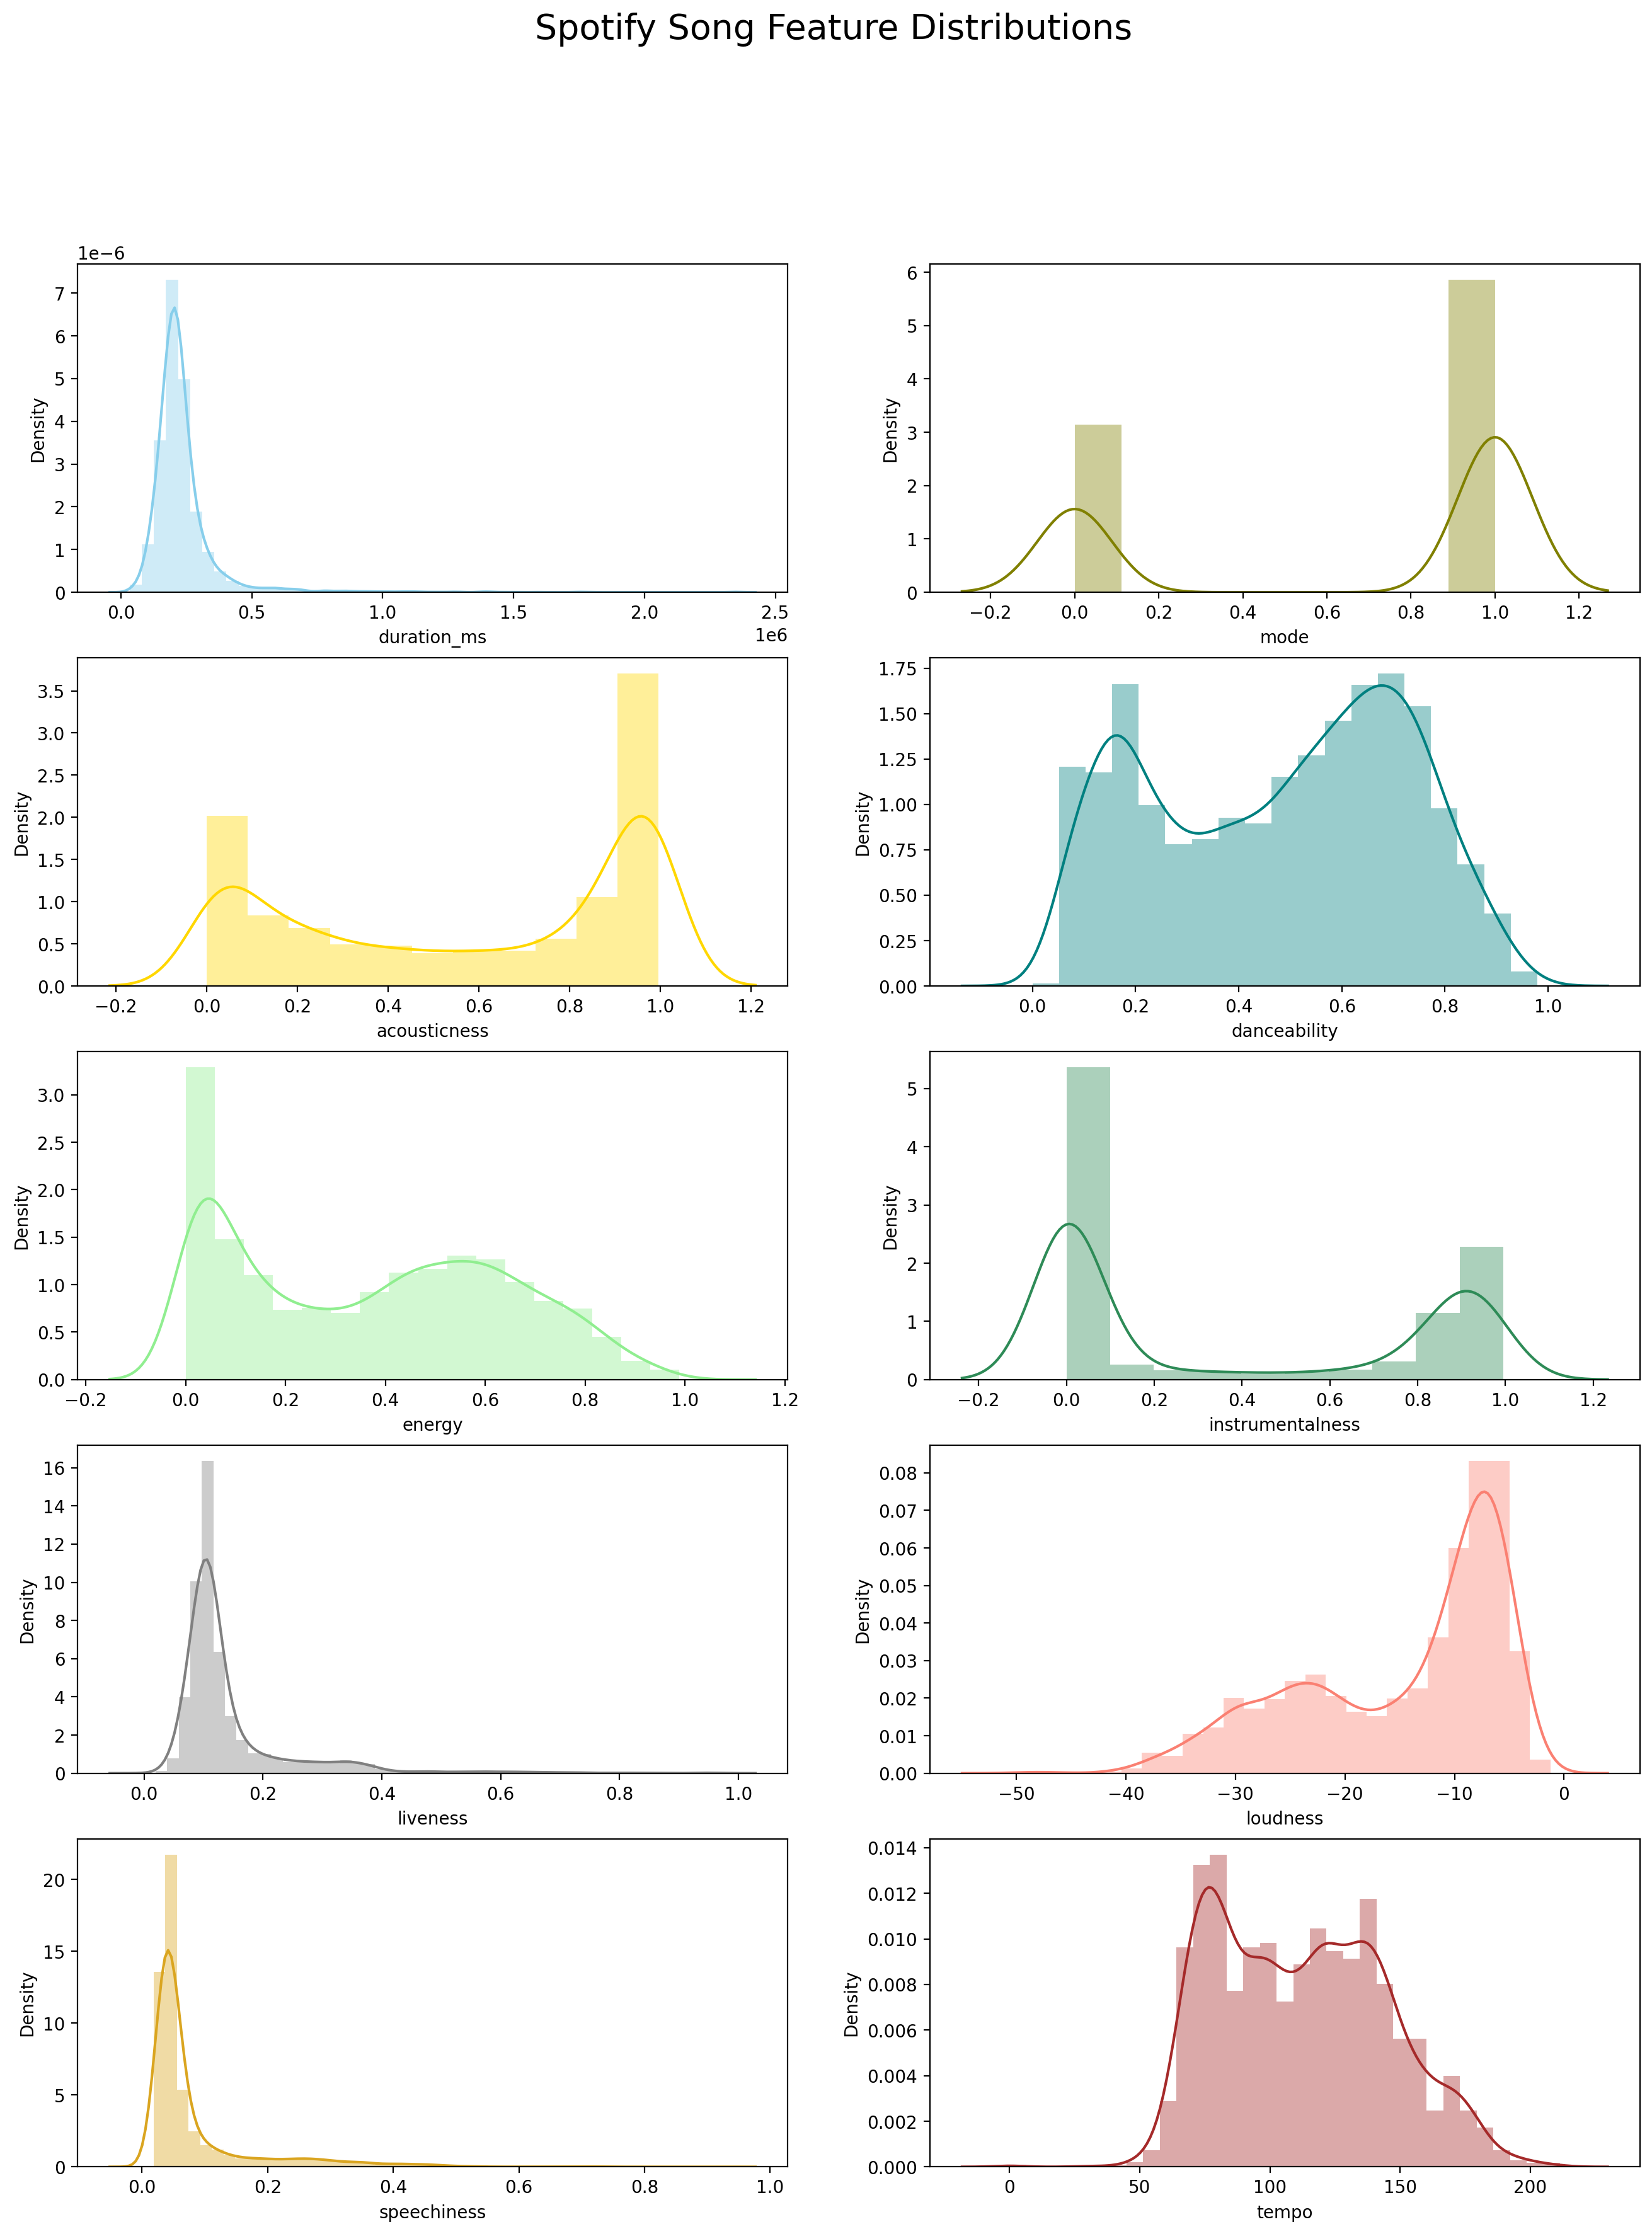

In [43]:
f, axes = plt.subplots(5, 2, figsize=(16,20), dpi=200)

sns.distplot( vis_data["duration_ms"] , color="skyblue", ax=axes[0, 0])
sns.distplot( vis_data["mode"] , color="olive", ax=axes[0, 1])
sns.distplot( vis_data["acousticness"] , color="gold", ax=axes[1, 0])
sns.distplot( vis_data["danceability"] , color="teal", ax=axes[1, 1])
sns.distplot( vis_data["energy"] , color="lightgreen", ax=axes[2, 0])
sns.distplot( vis_data["instrumentalness"] , color="seagreen", ax=axes[2, 1])
sns.distplot( vis_data["liveness"] , color="grey", ax=axes[3, 0])
sns.distplot( vis_data["loudness"] , color="salmon", ax=axes[3, 1])
sns.distplot( vis_data["speechiness"] , color="goldenrod", ax=axes[4, 0])
sns.distplot( vis_data["tempo"] , color="brown", ax=axes[4, 1])

f.suptitle('Spotify Song Feature Distributions', size=20);

### Analysis of feature distribution

See the feature distribution, we can see that most of the songs hover around 200,000 miliseconds, which comes to about 3.33 minutes, generally we can think of. Mostly songs are with a mode of 1, meaning that they are in a major key, and are more happy. 

### How are these features correlated with each other?

In [2]:
f, ax = plt.subplots(figsize=(16,9), dpi=200)

ax.set_title("Correlation of Spotify library's deep song features")

# compute correlation of all of the above metrics
corr = vis_data.corr()


# generate mask for top portion of corr matrix
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=sns.color_palette("RdYlBu", 10), annot=True,
            fmt=".2f", square=True, linewidths=.5, cbar_kws={"shrink": .5})

f.tight_layout();

NameError: name 'plt' is not defined

Above, we can see how these features tend to move with each other, or how they relate to one another. The darker red colors are inversely correlated, and the darker blue colors are positively correlated. There is a strong positive relationship between loudness and energy. We can also see some relatively strong inverse relationships here between energy and acousticness, which makes sense. Acoustic songs tend to be less energetic, and energetic songs tend to be less acoustic. Also, loudness and acousticness are inversely correlated, with the same principle applying. (That acoustic songs are quieter than non-acoustic songs.) The same applies for instrumental songs, meaning that songs without vocal presence tend to be quieter. These are all very useful and interesting observations!

### Which genres do I listen most?

In [45]:
# # get one hot encoded columns for artist genres
# genres = [x for x in df_features.columns if x[:12] == 'artist_genre']

# # create df of genres group by sum, sorting descending
# df_genres_sum = pd.DataFrame(
#     df_features[genres].sum().sort_values(ascending=False)).reset_index()

# # rename columns
# df_genres_sum.columns = ['genre', 'count']

# # clean column names
# df_genres_sum['genre'] = df_genres_sum['genre'].apply(lambda x: x[13:])

# # get top 10 most listened to genres
# df_genres_sum_top_10 = df_genres_sum[:15].copy()

# # get other genres
# others = df_genres_sum['count'][15:].sum()

# # sum all other genres not in top 10
# others_row = pd.DataFrame(data={'genre': ['others'], 'count': [others]})

# # concatenate the two dfs together
# pie_df = pd.concat([df_genres_sum_top_10, others_row])

# # create fig and axis
# fig, ax = plt.subplots(figsize=(20, 20), dpi=200)

# # get labels for doughnut
# data_labels = pie_df['genre'].values

# # separate data
# data = pie_df['count'].values

# # get wedges and text for chart
# wedges, texts, autotext = ax.pie(
#     data,
#     wedgeprops=dict(width=0.5),
#     startangle=-40,
#     colors=sns.color_palette("BrBG", 10),
#     autopct='%1.1f%%',
#     textprops={'fontsize': 20})

# # proportions
# bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)

# # more chart config
# kw = dict(
#     xycoords='data',
#     textcoords='data',
#     arrowprops=dict(arrowstyle="-"),
#     bbox=bbox_props,
#     zorder=0,
#     va="center",
#     fontsize=20)

# # annotation and labeling
# for i, p in enumerate(wedges):
#     ang = (p.theta2 - p.theta1) / 2. + p.theta1
#     y = np.sin(np.deg2rad(ang))
#     x = np.cos(np.deg2rad(ang))
#     horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
#     connectionstyle = "angle,angleA=0,angleB={}".format(ang)
#     kw["arrowprops"].update({"connectionstyle": connectionstyle})
#     ax.annotate(
#         data_labels[i],
#         xy=(x, y),
#         xytext=(1.35 * np.sign(x), 1.4 * y),
#         horizontalalignment=horizontalalignment,
#         **kw)

# # add super title
# fig.suptitle('Most listened to Genres', size=30)
# fig.tight_layout();

Here the data has been splitted into training and testing chunks, which will primarily help to observe the distribution of the data, and how the HDBSCAN object reacts to new data points after it has been trained.

In [79]:
# scale and normalise the data

train_scaler = MinMaxScaler().fit(df_features)
X_train_scaled = train_scaler.transform(df_features)

# create a dataframe from the scaled data
X_train_scaled = pd.DataFrame(
    X_train_scaled, columns=X_train.columns, index=X_train.index)

## Refinement

After implementing Principal Component Analysis to reduce the dimensionality of the data, the goal is to capture as much variance as possible, which ended up giving a lot of features, and not reducing the data's dimensions by that much. For example: 




In [47]:
# # fit a PCA object that captures 95% of variance, using however many components it takes
# dummy_pca = PCA(n_components=0.95, random_state=41).fit(X_train_scaled)

# print('=> dummy PCA obj has {} components, way too many!\n'.format(dummy_pca.n_components_))
# print("=> variance explained by {}'s dummy pca components {}\n".format(
#     username, sum(dummy_pca.explained_variance_ratio_)))

Below there is implemented a lower variance threshold, as well as some simple logic which keeps the number of components under 30 if the 70% threshold is not met initially.

Also, there is not initially included one-hot encoded features for the artist's record label, and it was able to get a significant increase in the amount of recommendations per user after adding them.

In [48]:
# print('=> fitting PCA obj\n')
# pca_obj = PCA(n_components=0.95, random_state=41).fit(X_train_scaled)

# if pca_obj.n_components_ > 75:
#     pca_obj = PCA(n_components=75, random_state=41).fit(X_train_scaled)
#     print('=> too many components! re-fitting pca object\n')
# else:
#     pass

# print('=> PCA obj has {} components\n'.format(pca_obj.n_components_))

# print("=> variance explained by {}'s pca components {}\n".format(
#     username, sum(pca_obj.explained_variance_ratio_)))

# print("=> fitting data to PCA Object\n")
# PCA_df = pd.DataFrame(
#     pca_obj.fit_transform(X_train_scaled))  # create df of scaled PCA data

In [49]:
# print('PCA obj parameters: ')
# display(pca_obj.get_params())

In [50]:
# scree(pca_obj)

The amount of each user's total songs can vary quite widely from user to user depending on how active they are. Below shows a dynamic way of determing how many data points should be set as the minimum for the HDBSCAN to determine whether or not it is a cluster. 

Below this, the HDBSCAN object has been created (which is immediately trained on the training data) which is set up for prediction at a later point. 

In [80]:
print("=> fitting HDBSCAN object\n")

# create hdbscan classifier fit on the PCA_df
hdbs = HDBSCAN(
    prediction_data=True,
    core_dist_n_jobs=3,
    min_cluster_size=2,
    cluster_selection_epsilon=0.75).fit(X_train_scaled)  

=> fitting HDBSCAN object



In [81]:
print('HDBSCAN parameters:')
display(hdbs.get_params())

HDBSCAN parameters:


{'algorithm': 'best',
 'allow_single_cluster': False,
 'alpha': 1.0,
 'approx_min_span_tree': True,
 'cluster_selection_epsilon': 0.75,
 'cluster_selection_method': 'eom',
 'core_dist_n_jobs': 3,
 'gen_min_span_tree': False,
 'leaf_size': 40,
 'match_reference_implementation': False,
 'memory': Memory(location=None),
 'metric': 'euclidean',
 'min_cluster_size': 2,
 'min_samples': None,
 'p': None,
 'prediction_data': True}

Below, there are cluster labels from the trained classifier, as well as the test cluster labels from the test data that was introduced at a later point.

In [82]:
# classifications from the training data
train_labels = hdbscan.approximate_predict(hdbs, X_train_scaled)

The next step is to add the assigned clusters to each of the test and train dataframes

In [84]:
# add new column to the test df with the centroid the HDBSCAN predicted
df_features['CENTROID'] = train_labels[0]

# add probabilities to train df
df_features['PROBABILITIES'] = hdbs.probabilities_

ValueError: Length of values (4123) does not match length of index (4340)

The below cell allows to compare the cluster distributions between two datasets, which we can then plot to see how evenly spread out the data is and how the classifier is working in a training and a testing scenario

Now that the classifier is working properly, now we can make API calls for specific playlists that a user might want to get recommendations from. It follows a very similar concept to above, where API calls are made to obtain playlist information, deep song features, album features, and artist features.

In [62]:
# get all songs from selected playlist
playlist_results, playlist_df = get_playlist_tracks(
    username, '37i9dQZF1EOffTWdNyiLmQ', sp)

# get deep song info from playlist songs
playlist_results, playlist_df = get_deep_song_info(playlist_results,
                                                   playlist_df, token, sp)

# get album info for all songs in that playlist
playlist_results, playlist_df = get_album_info(playlist_df, token, sp)

# get artist info for all songs in that playlist
playlist_results, playlist_df = get_artist_info(playlist_df, token, sp)

Here you can see a sample of the playlist that has been selected to query, which is "Latest"; this is a playlist curated by the Hype Machine, but any playlist not owned by the user can be used for recommendations. This specific playlist is great as it is very diverse in genres and is updated very frequently with new music.


In [63]:
display(playlist_df.sample(10))

,song_name,duration_ms,artist_name,artist_id,album_id,album_name,release_date,popularity,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,record_label,album_popularity,artist_followers,artist_genres,artist_popularity
0F5BcfCZoTVgqYV84aUHDP,"Rêverie, L. 68 (Arr. Badzura)",368814,Claude Debussy,1Uff91EOsvd99rtAupatMP,352Wkqqs4TsE8m7dbYNPML,Debussy: A Musical Genius,2020-10-15,45,False,0.175,0.0669,5,-21.458,1,0.0447,0.943,0.604,0.131,0.0401,80.317,4,"UMG Recordings, Inc.",40,1052734,"[classical, impressionism, post-romantic_era]",70
14WJTJeujMUYAMftYxbFs1,Foggy Moon: New Horizons - Sleep Edit,274709,Stelliform,5p0EjNXCzKentCgIDfo26N,0pMINuWZd9Hnu56l1a2GWH,Foggy Moon: New Horizons (Sleep Edit),2020-01-24,18,False,0.147,0.184,2,-23.611,1,0.0459,0.955,0.968,0.147,0.0314,91.491,3,Stelliform,12,95,[ambient_worship],34
31ZPBCSPLTX4U2nMpiZbT4,Dreams,188571,Misha,4dPYdHTBZATnTYABJ39sY7,0MkgrBUwohzRQVW5k2Z8Ih,Dreams,2020-03-18,42,False,0.864,0.407,8,-15.02,1,0.0632,0.444,0.862,0.125,0.116,111.965,4,Chillhop Music,36,2042,[chillhop],46
2mNQl3DEWtkrwKllwYpxi0,"Pavane, Op. 50 (Version for Piano)",359463,Gabriel Fauré,2gClsBep1tt1rv1CN210SO,4QYFeRjBgVCv8Vrb3cK7wI,The French Album,2020-08-14,56,False,0.392,0.0152,6,-30.684,0,0.0424,0.996,0.885,0.081,0.12,74.963,4,Cedille,49,147068,"[classical, post-romantic_era]",62
0cIW3VDH2FOnO3WGQYZ1MZ,Familiar,213969,Belot,05saREsqgyy8WODHpOIrKK,2uBZAPxV889fqgWZBjxcjx,Familiar,2020-04-06,49,False,0.828,0.412,2,-9.921,1,0.0427,0.545,2.58e-05,0.229,0.139,99.988,4,Belot,42,806,[chill_pop],35
2EdkWV74XJk9FhmfnMixos,Oceania,245124,chromonicci,746nA9NSKsqBDRk343UtkE,4vnwPuF22DEFcOOIcKq3uh,Oceania,2020-06-11,44,False,0.501,0.411,6,-13.714,0,0.294,0.135,0.894,0.111,0.536,89.998,4,Chillhop Music,38,11604,"[chillhop, future_bass, vapor_twitch]",51
3K5v9paUrw1sDVtZeeBxwt,Wild World,194625,des hume,0jR4cjFAcy3TmLw06xdKxh,0N4WAn04Ny96Yge3J75G8U,Wild World,2020-04-24,50,False,0.644,0.382,7,-14.721,1,0.071,0.552,0.822,0.123,0.671,169.977,4,des hume initiative,43,466,[chill_pop],36
5RSxbZ20bQDjptmMTJLwtt,Sitting near the Sun,326721,Young Collective,1gwOFmQwi27OqZrZ3okCbj,4rsa4KRh264inuwgO1uM4V,Rest. Repeat,2020-05-08,19,False,0.17,0.181,9,-17.806,1,0.0424,0.808,0.942,0.119,0.0358,125.466,3,from 88 publishing,22,1524,[ambient_worship],26
0bEzChVO9UpVwC7tI5IhI4,Girls Just Wanna Have Sun,170000,SAINT WKND,4vO1cl2ndGrUPSl6IYTHs6,3XUWduQjgFE9BZj92owp74,Girls Just Wanna Have Sun,2020-06-11,31,False,0.608,0.288,5,-9.732,1,0.0632,0.585,0.403,0.0887,0.151,76.995,4,Chillhop Music,24,16557,[deep_tropical_house],52
1G3QPQkoXvpChjNUhd6Tfs,The Arts and the Hours,285442,Jean-Philippe Rameau,4JSWO1Pf2zV991fq64uAce,4omnRCjOvnHa3ETQlqZpd1,"Rameau, Ólafsson: The Arts and the Hours",2020-03-06,59,False,0.415,0.026,1,-36.7,1,0.0496,0.995,0.938,0.107,0.268,136.191,4,Deutsche Grammophon (DG),53,51155,"[baroque, classical, early_music, french_baroq...",53


In [64]:
# return a cleaned df with more features
df_playlist_features = clean_data(playlist_df) 

The below function makes the playlist df the same size as the training df. It does this by dropping any columns that are not present in the training df, and adding columns that were present in the training df that are not in the playlist df.

In [65]:
# make df playlist columns match training data
df_playlist_features = make_dfs_comparable(df_features, df_playlist_features) 

In [66]:
df_playlist_features

,duration_ms,popularity,explicit,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,album_popularity,artist_followers,artist_popularity,release_year,time_signature_3,time_signature_4,time_signature_5,key_0,key_1,key_2,key_4,key_5,key_6,key_7,key_8,key_9,key_10,key_11,key_3,time_signature_0,time_signature_1
2EdkWV74XJk9FhmfnMixos,245124.0,44.0,0.0,0.501,0.41100,-13.714,0.0,0.2940,0.1350,0.894000,0.1110,0.5360,89.998,38.0,11604,51,2020.0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3xNXGFG9H7CXCtGcprGzpB,168500.0,55.0,0.0,0.798,0.49300,-10.668,0.0,0.0466,0.9490,0.777000,0.1150,0.3070,126.002,50.0,16695,53,2020.0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3MCxDQxoCtXkVgkFtobXRX,165755.0,50.0,0.0,0.581,0.25600,-11.090,0.0,0.0291,0.7980,0.886000,0.0971,0.2850,138.868,43.0,9433,51,2020.0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
0F5BcfCZoTVgqYV84aUHDP,368814.0,45.0,0.0,0.175,0.06690,-21.458,1.0,0.0447,0.9430,0.604000,0.1310,0.0401,80.317,40.0,1052734,70,2020.0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
24CCFicvmdfcZyXeNp42UO,235650.0,39.0,0.0,0.585,0.48000,-8.113,1.0,0.0788,0.6950,0.007000,0.0899,0.2330,150.037,33.0,326,26,2020.0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2mNQl3DEWtkrwKllwYpxi0,359463.0,56.0,0.0,0.392,0.01520,-30.684,0.0,0.0424,0.9960,0.885000,0.0810,0.1200,74.963,49.0,147068,62,2020.0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1mD7SoxO9qiuoTbg4hbVk2,214285.0,47.0,0.0,0.868,0.21500,-13.479,1.0,0.0788,0.6090,0.888000,0.1110,0.2330,91.009,40.0,9763,50,2020.0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1G3QPQkoXvpChjNUhd6Tfs,285442.0,59.0,0.0,0.415,0.02600,-36.700,1.0,0.0496,0.9950,0.938000,0.1070,0.2680,136.191,53.0,51155,53,2020.0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
7MaLgi5mMMsRaRUwlw3mNf,133120.0,38.0,0.0,0.140,0.00158,-39.000,1.0,0.0475,0.9720,0.000073,0.0630,0.0574,140.811,32.0,34088,44,2020.0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
43Ef4i9PyqtXJK29cIeC76,128780.0,53.0,0.0,0.387,0.15100,-7.376,0.0,0.0441,0.8030,0.488000,0.1060,0.0386,81.938,46.0,2645,46,2020.0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [67]:
# create a dataframe from the scaled data
playlist_scaled = train_scaler.fit_transform(df_playlist_features)

# create df from scaled test data
playlist_scaled = pd.DataFrame(
    playlist_scaled,
    columns=df_playlist_features.columns,
    index=df_playlist_features.index)

Now we start the clustering process on the playlist data, using the trained classifier from the user's saved songs.

In [68]:
# playlist_pca_obj = pca_obj.transform(playlist_scaled)
# playlist_pca_df = pd.DataFrame(playlist_pca_obj)

# classify on playlist songs
playlist_labels = hdbscan.approximate_predict(hdbs, playlist_scaled)

# assign centroid number to pca df
playlist_scaled['CENTROID'] = playlist_labels[0]

In [69]:
# add centroid to original features df
df_playlist_features['CENTROID'] = playlist_labels[0] 

# add cluster probability, same as in training/testing
df_playlist_features['PROBABILITY'] = playlist_labels[1] 

After the songs are classified, the results are filtered to remove any songs that are already in the user's library, and any songs that belong to the cluster with -1 as the label, meaning it didn't get classified. 

In [70]:
df_playlist_features['CENTROID'].value_counts()

-1     27
 36     2
 29     1
Name: CENTROID, dtype: int64

In [71]:
# filter out songs that are in the library, and are also not in a cluster
res = df_playlist_features[
    (~df_playlist_features.index.isin(df_features.index)) &
    (df_playlist_features['CENTROID'] != -1)]  

In [72]:
# sort value by cluster confidence, then by popularity
res = res.sort_values(by=['PROBABILITY', 'popularity'], ascending=False)

In [73]:
# show all recommendations before being filtered down for the user
display(res)

,duration_ms,popularity,explicit,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,album_popularity,artist_followers,artist_popularity,release_year,time_signature_3,time_signature_4,time_signature_5,key_0,key_1,key_2,key_4,key_5,key_6,key_7,key_8,key_9,key_10,key_11,key_3,time_signature_0,time_signature_1,CENTROID,PROBABILITY
6HqbnScUlmgt8d5Jd4Ok49,233333.0,26.0,0.0,0.158,0.0577,-26.172,1.0,0.0325,0.995,0.943000,0.0842,0.0943,58.540,26.0,61262,49,2020.0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,36,0.350395
0bEzChVO9UpVwC7tI5IhI4,170000.0,31.0,0.0,0.608,0.2880,-9.732,1.0,0.0632,0.585,0.403000,0.0887,0.1510,76.995,24.0,16557,52,2020.0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,36,0.286076
0fJgXnPVJsZvttEtuiIJlN,151500.0,18.0,0.0,0.384,0.0443,-17.641,1.0,0.0424,0.969,0.000148,0.0821,0.1050,117.364,12.0,1985,36,2020.0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,29,0.197454


## Recommendations & Results

Below are a sample of recommendations that would be made to the user, which are sorted by the cluster confidence as well as by the popularity of the song. The `show_diverse_recs` function re-orders the recommendations; it makes sure that all clusters are represented if there are more than 1 cluster in the recommendations returned. Above we can see that cluster 261 is quite highly represented, (most likely pop) so it would be foolish to only return songs from 261. `show_diverse_recs` makes sure that the highest 5 probabilities from each cluster are represented for diversity's sake.

In [74]:
# order recommendations alternating clusters
# only if there are songs from at least two different clusters
if res.shape[0] > 5:
    res = show_diverse_recs(res, 5)
    display(res)
else:
    display(res)

,duration_ms,popularity,explicit,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,album_popularity,artist_followers,artist_popularity,release_year,time_signature_3,time_signature_4,time_signature_5,key_0,key_1,key_2,key_4,key_5,key_6,key_7,key_8,key_9,key_10,key_11,key_3,time_signature_0,time_signature_1,CENTROID,PROBABILITY
6HqbnScUlmgt8d5Jd4Ok49,233333.0,26.0,0.0,0.158,0.0577,-26.172,1.0,0.0325,0.995,0.943000,0.0842,0.0943,58.540,26.0,61262,49,2020.0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,36,0.350395
0bEzChVO9UpVwC7tI5IhI4,170000.0,31.0,0.0,0.608,0.2880,-9.732,1.0,0.0632,0.585,0.403000,0.0887,0.1510,76.995,24.0,16557,52,2020.0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,36,0.286076
0fJgXnPVJsZvttEtuiIJlN,151500.0,18.0,0.0,0.384,0.0443,-17.641,1.0,0.0424,0.969,0.000148,0.0821,0.1050,117.364,12.0,1985,36,2020.0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,29,0.197454


The below function prints out the song names and artists based on the song IDs. The results are very accurate. 

In [75]:
print_song_names(res, sp)

Holding the Contradiction by The Brilliance

Girls Just Wanna Have Sun by SAINT WKND

I Wonder by Narrow Skies

